In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
%matplotlib inline

In [5]:
df = pd.read_excel("UCI_Credit_Card (1).xlsx")
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
df.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [7]:
#Renaming the column

df.rename(columns={'default.payment.next.month': 'IsDefaulter'}, inplace=True)

In [8]:
# count values in the label column 'IsDefaulter'
df['IsDefaulter'].value_counts()

0    23364
1     6636
Name: IsDefaulter, dtype: int64

In [9]:
## verify both the values are described in the data description (1=male, 2=female)
df['SEX'].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

In [10]:
# Value 0, 5, 6 not described and are unknown in data description (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
#These can be dropped as their count is low
df['EDUCATION'].value_counts()


2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [11]:
# Dropping EDUCATION value 0,5,6 as there are unknown in data description
df = df[~df['EDUCATION'].isin([0,5,6])]
df['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
4      123
Name: EDUCATION, dtype: int64

In [12]:
# Verify the values in MARRIAGE column
df['MARRIAGE'].value_counts()

2    15806
1    13477
3      318
0       54
Name: MARRIAGE, dtype: int64

In [13]:
# Dropping values 0 in MARRIAGE column as it is unknown in data description
df = df[~df['MARRIAGE'].isin([0])]
df['MARRIAGE'].value_counts()

2    15806
1    13477
3      318
Name: MARRIAGE, dtype: int64

In [14]:
df['PAY_0'].value_counts()
# Value -2 and 9 is not given in the coumn PAY_N, while data description is
# September 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)

 0    14499
-1     5633
 1     3662
-2     2708
 2     2640
 3      320
 4       76
 5       24
 8       19
 6       11
 7        9
Name: PAY_0, dtype: int64

In [15]:
#correcting `PAY_n` features by adding 1 to each attribute and grouping together the resulting values of '0' and '-1' (since 0 does not correspond to any value previously described).
# assuming (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)

df[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']] += 1

In [16]:
# grouping together the resulting values of '0' and '-1' in columns PAY_N (since 0 does not correspond to any value previously described)
pay_columns = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
df[pay_columns] = df[pay_columns].replace(0, 1)

In [17]:
# Verify the changed values in columns PAY_N
df['PAY_0'].value_counts()

 1    20132
 2     3662
-1     2708
 3     2640
 4      320
 5       76
 6       24
 9       19
 7       11
 8        9
Name: PAY_0, dtype: int64

In [18]:
# Data Visualization

<Axes: xlabel='IsDefaulter', ylabel='count'>

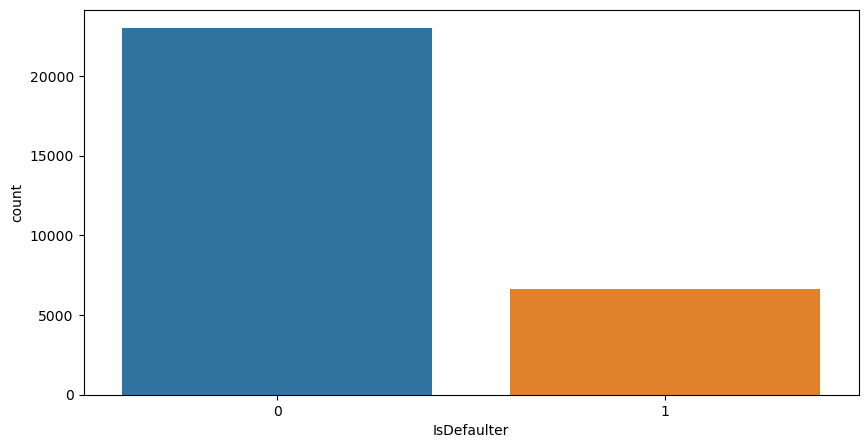

In [19]:
# The following graph shows the count of defaulters vs the count of non-defaulters.
plt.figure(figsize=(10,5))
sns.countplot(x = 'IsDefaulter', data = df)

In [20]:
# Visulize how different categories like sex, marriage and education affects the defaulties.
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']
df_cat = df[categorical_features]
df_cat['Defaulter'] = df['IsDefaulter']

In [21]:
# CHnage the values to description
df_cat.replace({'SEX': {1 : 'MALE', 2 : 'FEMALE'}, 'EDUCATION' : {1 : 'graduate school', 2 : 'university', 3 : 'high school', 4 : 'others'}, 'MARRIAGE' : {1 : 'married', 2 : 'single', 3 : 'others'}}, inplace = True)

<Figure size 1000x500 with 0 Axes>

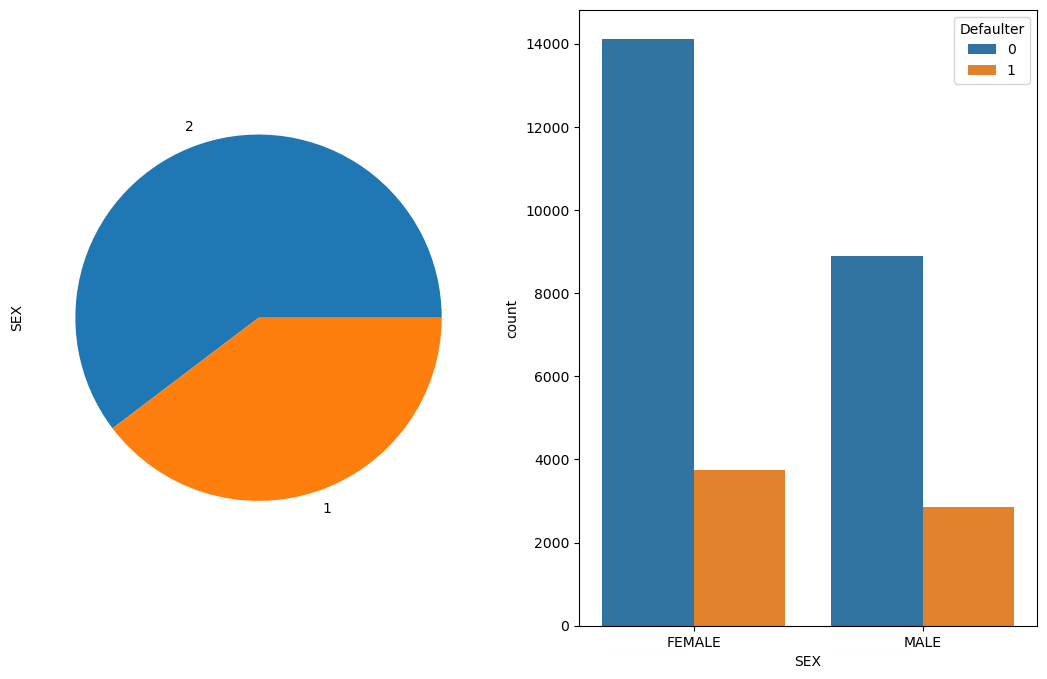

<Figure size 1000x500 with 0 Axes>

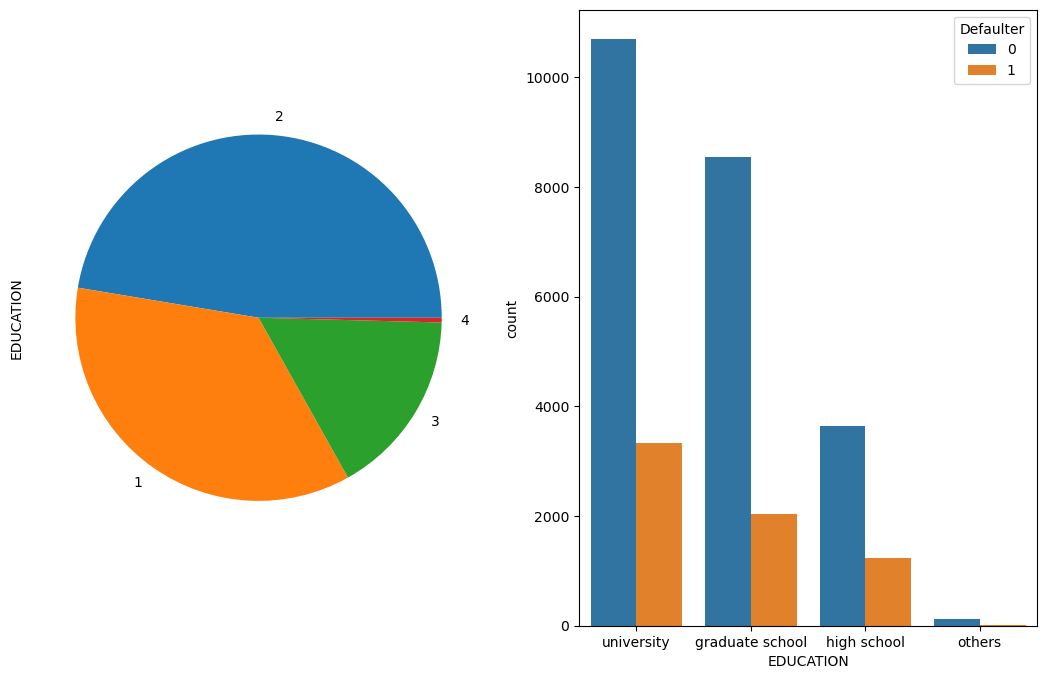

<Figure size 1000x500 with 0 Axes>

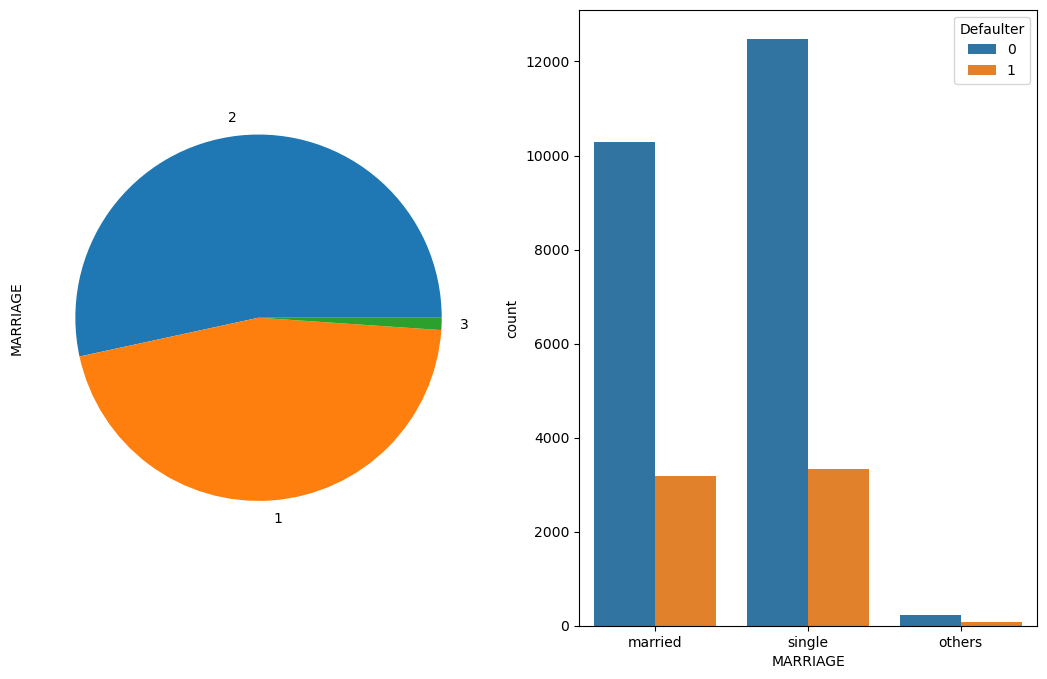

In [22]:
for col in categorical_features:
  plt.figure(figsize=(10,5))
  fig, axes = plt.subplots(ncols=2,figsize=(13,8))
  df[col].value_counts().plot(kind="pie",ax = axes[0],subplots=True)
  sns.countplot(x = col, hue = 'Defaulter', data = df_cat)

In [23]:
df['LIMIT_BAL'].describe()

count      29601.000000
mean      167550.544914
std       129944.020953
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

<Axes: xlabel='IsDefaulter', ylabel='LIMIT_BAL'>

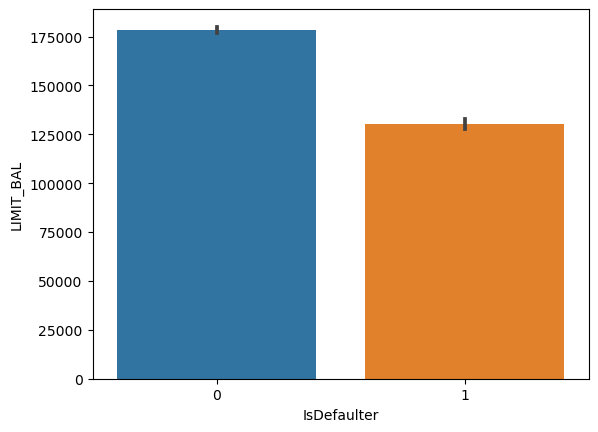

In [24]:
sns.barplot(x='IsDefaulter', y='LIMIT_BAL', data=df)

In [25]:
#renaming columns

df.rename(columns={'PAY_0':'PAY_SEPT','PAY_2':'PAY_AUG','PAY_3':'PAY_JUL','PAY_4':'PAY_JUN','PAY_5':'PAY_MAY','PAY_6':'PAY_APR'},inplace=True)
df.rename(columns={'BILL_AMT1':'BILL_AMT_SEPT','BILL_AMT2':'BILL_AMT_AUG','BILL_AMT3':'BILL_AMT_JUL','BILL_AMT4':'BILL_AMT_JUN','BILL_AMT5':'BILL_AMT_MAY','BILL_AMT6':'BILL_AMT_APR'}, inplace = True)
df.rename(columns={'PAY_AMT1':'PAY_AMT_SEPT','PAY_AMT2':'PAY_AMT_AUG','PAY_AMT3':'PAY_AMT_JUL','PAY_AMT4':'PAY_AMT_JUN','PAY_AMT5':'PAY_AMT_MAY','PAY_AMT6':'PAY_AMT_APR'},inplace=True)

In [26]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,...,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,PAY_AMT_SEPT,PAY_AMT_AUG,PAY_AMT_JUL,PAY_AMT_JUN,PAY_AMT_MAY,PAY_AMT_APR,IsDefaulter
0,1,20000,2,2,1,24,3,3,1,1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,1,3,1,1,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,1,1,1,1,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,1,1,1,1,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,1,1,1,1,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [27]:
# Sort values in column AGE
sorted_age_counts = df['AGE'].value_counts().sort_values(ascending=False)
sorted_age_counts

29    1593
27    1455
28    1397
30    1382
26    1245
31    1205
25    1176
34    1147
32    1143
33    1127
24    1117
35    1098
36    1094
37    1023
39     941
38     936
23     917
40     850
41     811
42     786
44     691
43     666
45     600
46     557
22     553
47     492
48     457
49     444
50     402
51     333
53     317
52     299
54     242
55     207
56     175
58     122
57     120
59      82
60      66
21      64
61      56
62      44
63      31
64      30
65      24
66      23
67      16
69      15
70      10
68       5
73       4
75       3
72       3
71       3
79       1
74       1
Name: AGE, dtype: int64

In [28]:
# Define age groups
age_bins = [0, 20, 30, 40, 50, 60, 70, 120]
age_labels = ['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70+']

# Create a new column 'Age_Group' to store the age group for each record
df['Age_Group'] = pd.cut(df['AGE'], bins=age_bins, labels=age_labels)


In [29]:
# Count the number of defaulters and non-defaulters in each age group
age_group_counts = df.groupby(['Age_Group', 'IsDefaulter']).size().unstack(fill_value=0)

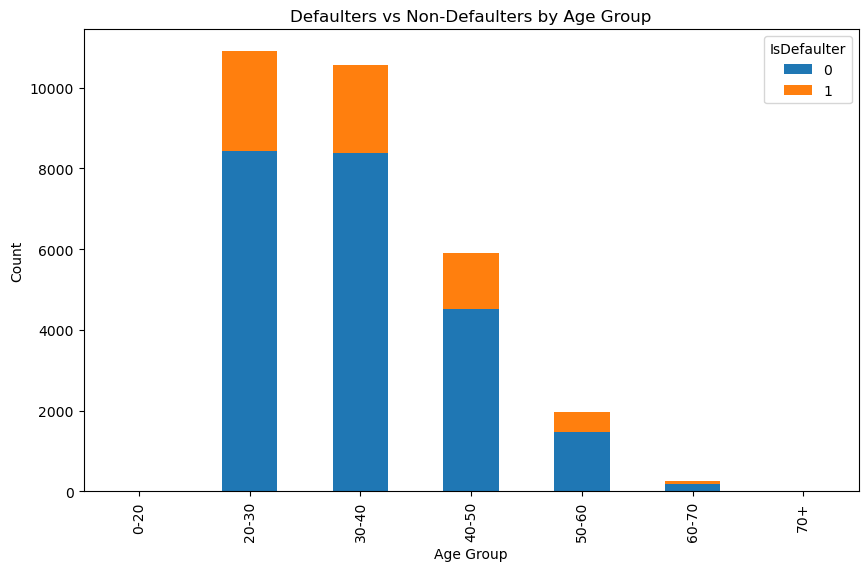

In [30]:
# Plot the bar graph
age_group_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Defaulters vs Non-Defaulters by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.show()

Text(0.5, 1.0, 'Default Payment Next Month Distribution')

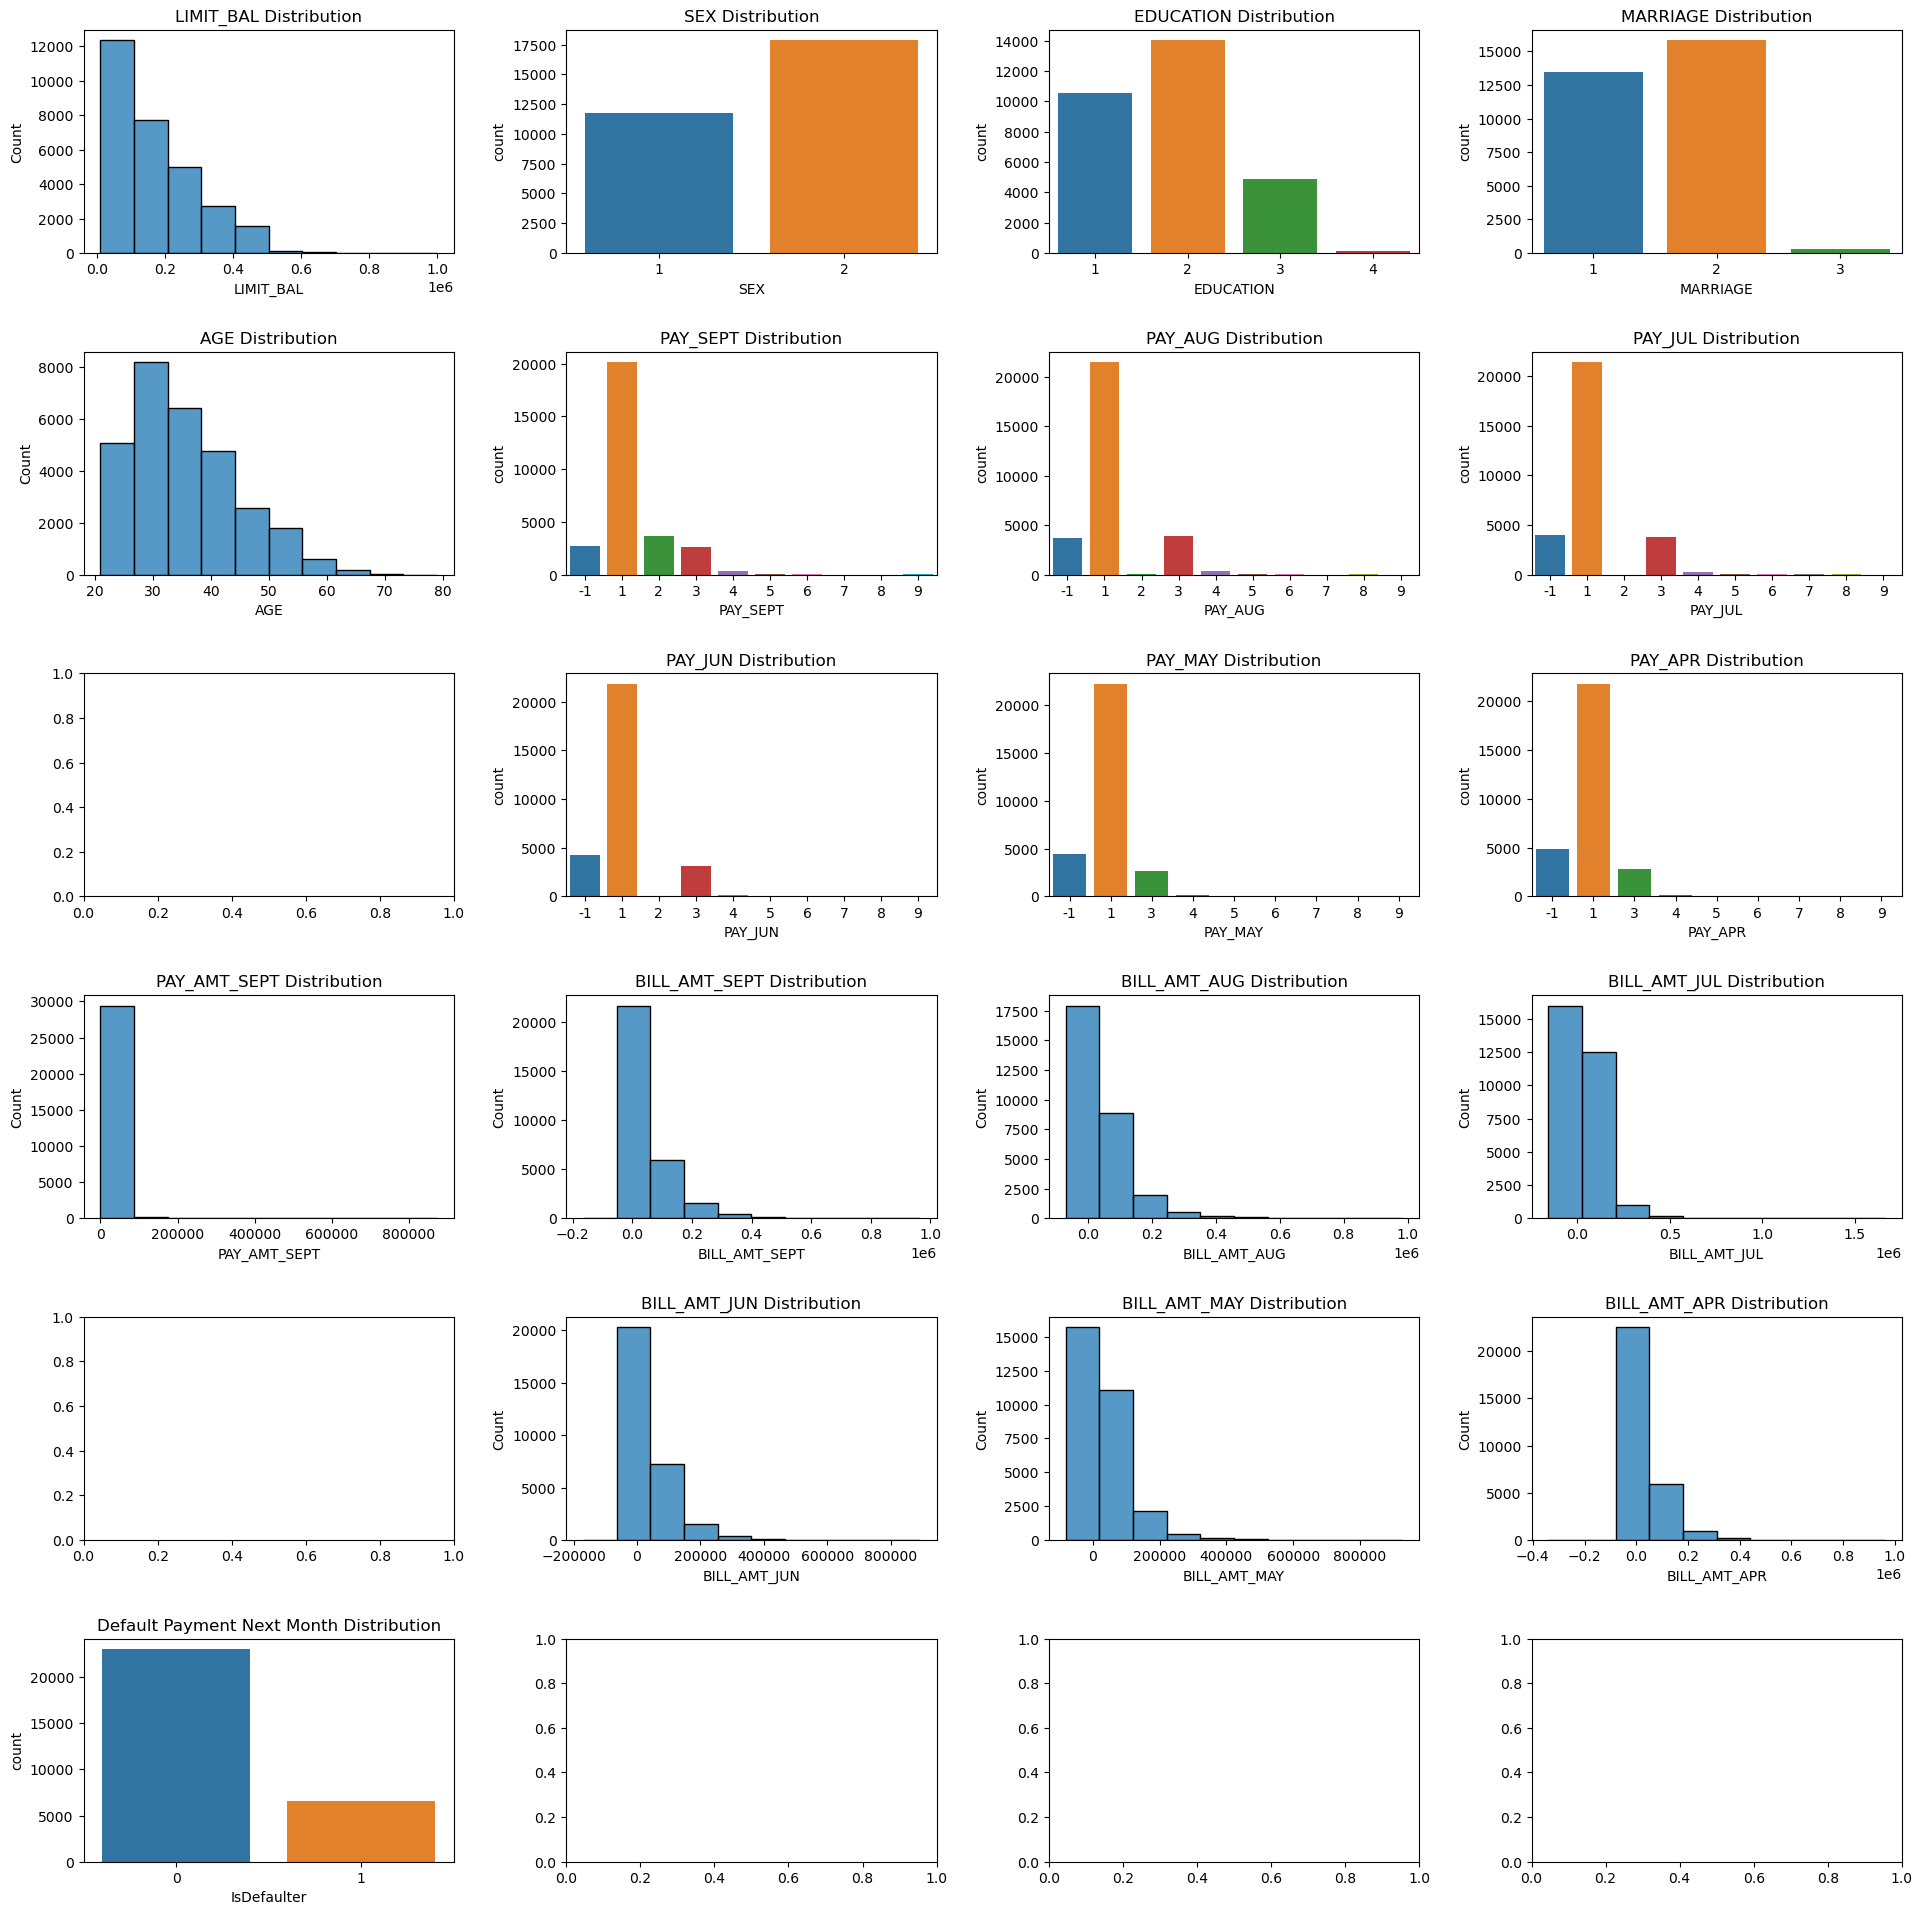

In [31]:
# Generate multiple insights
fig, axes = plt.subplots(6, 4, figsize=(20, 20)) # Adjust the size and layout according to the number of variables
fig.tight_layout(pad=5.0)

# Histogram of LIMIT_BAL
sns.histplot(df['LIMIT_BAL'], bins=10, kde=False, ax=axes[0, 0])
axes[0, 0].set_title('LIMIT_BAL Distribution')

# Count plot for categorical variables SEX, EDUCATION, MARRIAGE
sns.countplot(x='SEX', data=df, ax=axes[0, 1])
axes[0, 1].set_title('SEX Distribution')

sns.countplot(x='EDUCATION', data=df, ax=axes[0, 2])
axes[0, 2].set_title('EDUCATION Distribution')

sns.countplot(x='MARRIAGE', data=df, ax=axes[0, 3])
axes[0, 3].set_title('MARRIAGE Distribution')

# AGE distribution
sns.histplot(df['AGE'], bins=10, kde=False, ax=axes[1, 0])
axes[1, 0].set_title('AGE Distribution')

# PAY_X distributions (PAY_1, PAY_2, etc.)
sns.countplot(x='PAY_SEPT', data=df, ax=axes[1, 1])
axes[1, 1].set_title('PAY_SEPT Distribution')

sns.countplot(x='PAY_AUG', data=df, ax=axes[1, 2])
axes[1, 2].set_title('PAY_AUG Distribution')

sns.countplot(x='PAY_JUL', data=df, ax=axes[1, 3])
axes[1, 3].set_title('PAY_JUL Distribution')

sns.countplot(x='PAY_JUN', data=df, ax=axes[2, 1])
axes[2, 1].set_title('PAY_JUN Distribution')

sns.countplot(x='PAY_MAY', data=df, ax=axes[2, 2])
axes[2, 2].set_title('PAY_MAY Distribution')

sns.countplot(x='PAY_APR', data=df, ax=axes[2, 3])
axes[2, 3].set_title('PAY_APR Distribution')


# # BILL_AMT_X distributions
sns.histplot(df['BILL_AMT_SEPT'], bins=10, kde=False, ax=axes[3, 1])
axes[3, 1].set_title('BILL_AMT_SEPT Distribution')

sns.histplot(df['BILL_AMT_AUG'], bins=10, kde=False, ax=axes[3, 2])
axes[3, 2].set_title('BILL_AMT_AUG Distribution')

sns.histplot(df['BILL_AMT_JUL'], bins=10, kde=False, ax=axes[3, 3])
axes[3, 3].set_title('BILL_AMT_JUL Distribution')

sns.histplot(df['BILL_AMT_JUN'], bins=10, kde=False, ax=axes[4, 1])
axes[4, 1].set_title('BILL_AMT_JUN Distribution')

sns.histplot(df['BILL_AMT_MAY'], bins=10, kde=False, ax=axes[4, 2])
axes[4, 2].set_title('BILL_AMT_MAY Distribution')

sns.histplot(df['BILL_AMT_APR'], bins=10, kde=False, ax=axes[4, 3])
axes[4, 3].set_title('BILL_AMT_APR Distribution')

# # ... (similar plots for BILL_AMT2, BILL_AMT3, etc.)

# # PAY_AMT_X distributions
sns.histplot(df['PAY_AMT_SEPT'], bins=10, kde=False, ax=axes[3, 0])
axes[3, 0].set_title('PAY_AMT_SEPT Distribution')

# # ... (similar plots for PAY_AMT2, PAY_AMT3, etc.)

# # Correlation heatmap
# corr = data.corr()
# sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[4, 0])
# axes[4, 0].set_title('Correlation Heatmap')
# plt.subplots_adjust(top=0.9)
# axes[4, 0].get_shared_x_axes().join(axes[4, 0], axes[4, 1], axes[4, 2], axes[4, 3])
# for ax in axes[4, 1:]:
#     ax.remove()

# # Default payment next month distribution
sns.countplot(x='IsDefaulter', data=df, ax=axes[5, 0])
axes[5, 0].set_title('Default Payment Next Month Distribution')

# # ... (additional plots for other insights can be added)

# # Showing the plots
# plt.show()

Model 1 using all features

In [32]:
from sklearn.model_selection import train_test_split

# # Split the data into features (X) and the target variable (y)

#Removed 'ID' and 'Age_Grouped' from the features
X_all = ['LIMIT_BAL','SEX','EDUCATION',	'MARRIAGE',	'AGE',	'PAY_SEPT',	'PAY_AUG',	'PAY_JUL','PAY_JUN', 'PAY_MAY', 'PAY_APR', 'BILL_AMT_SEPT', 'BILL_AMT_AUG', 'BILL_AMT_JUL', 'BILL_AMT_JUN', 'BILL_AMT_MAY',	'BILL_AMT_APR',	'PAY_AMT_SEPT',	'PAY_AMT_AUG',	'PAY_AMT_JUL',	'PAY_AMT_JUN',	'PAY_AMT_MAY',	'PAY_AMT_APR']
y_all = pd.Series(['IsDefaulter'])
y_array=y_all.values
y=y_array.ravel()

# Split the data into a training set (e.g., 80% of the data) and a testing set (e.g., 20% of the data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(df[X_all], df[y_all], test_size=0.2, random_state=42)

# The 'test_size' parameter determines the proportion of data used for testing (e.g., 0.2 means 20% for testing).
# The 'random_state' parameter is used to ensure reproducibility. You can set it to any integer value.


In [36]:
#!pip install xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'XGBoost': XGBClassifier()
}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Display the results
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", report)
    print("=" * 50)


Model: Logistic Regression
Accuracy: 0.78
Classification Report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.87      4591
           1       0.00      0.00      0.00      1330

    accuracy                           0.78      5921
   macro avg       0.39      0.50      0.44      5921
weighted avg       0.60      0.78      0.68      5921

Model: Decision Tree
Accuracy: 0.72
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.82      4591
           1       0.39      0.41      0.40      1330

    accuracy                           0.72      5921
   macro avg       0.61      0.61      0.61      5921
weighted avg       0.73      0.72      0.73      5921

Model: Random Forest
Accuracy: 0.81
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.94      0.88      4591
           1       0.64      0.35      0.45      13

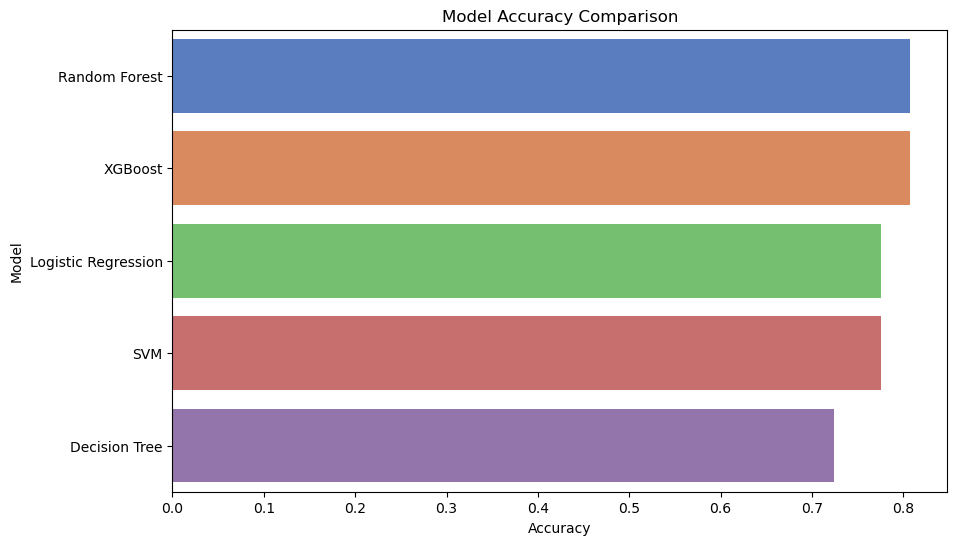

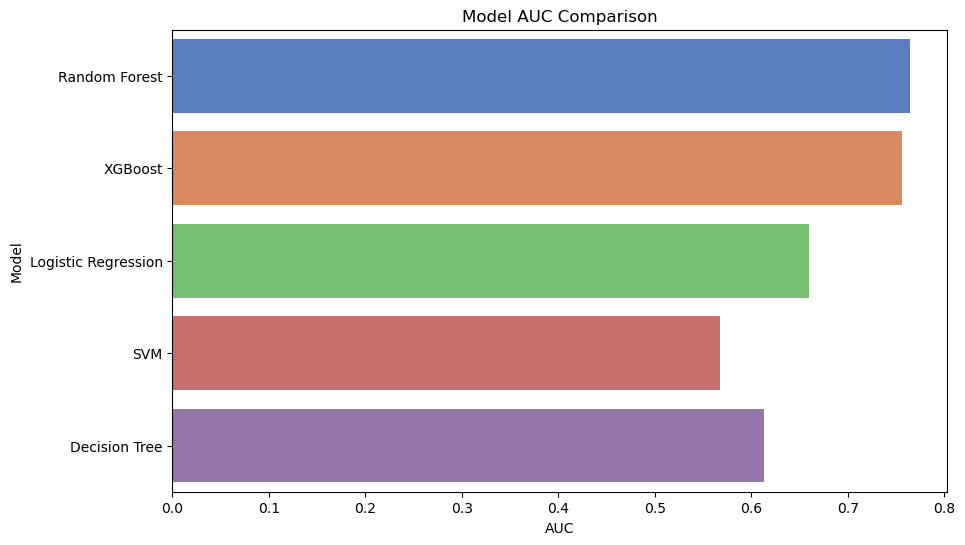

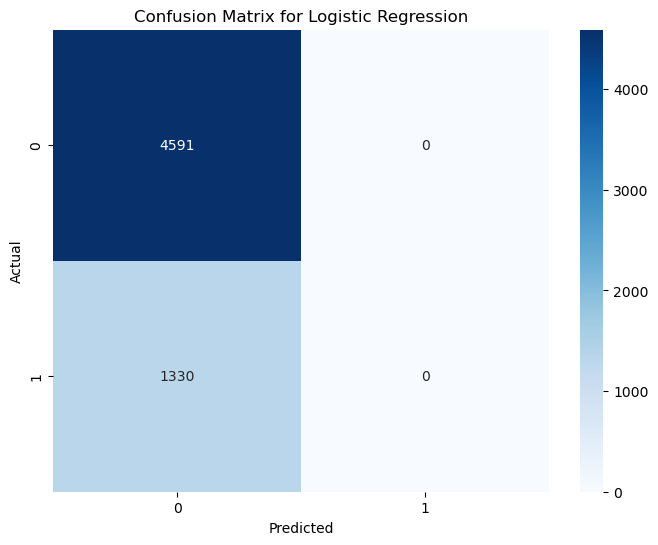

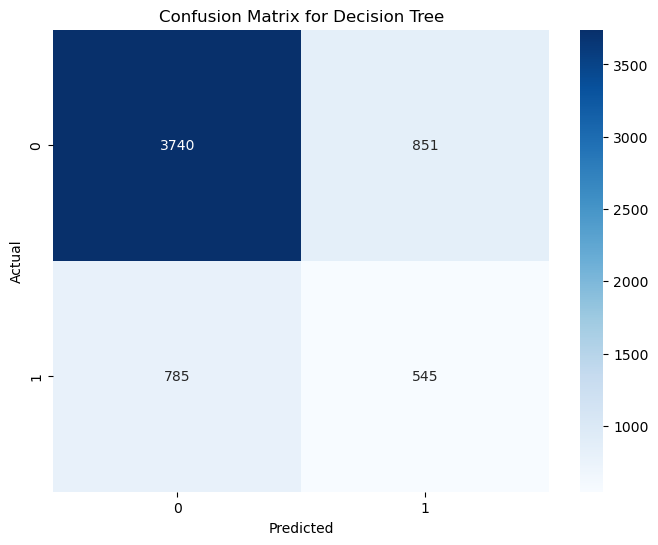

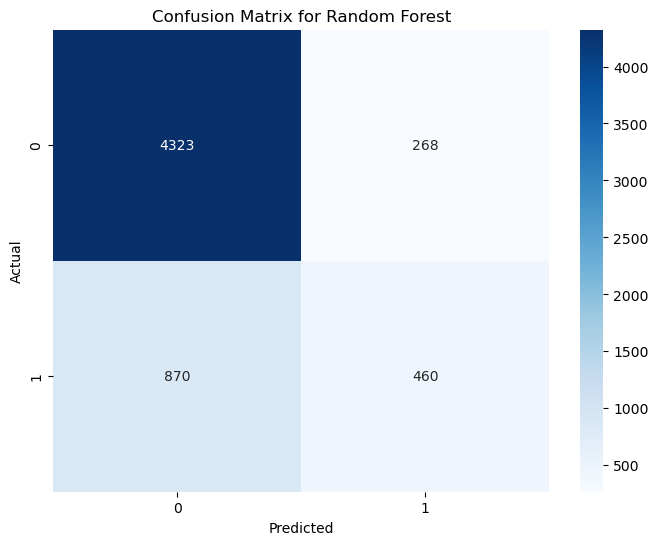

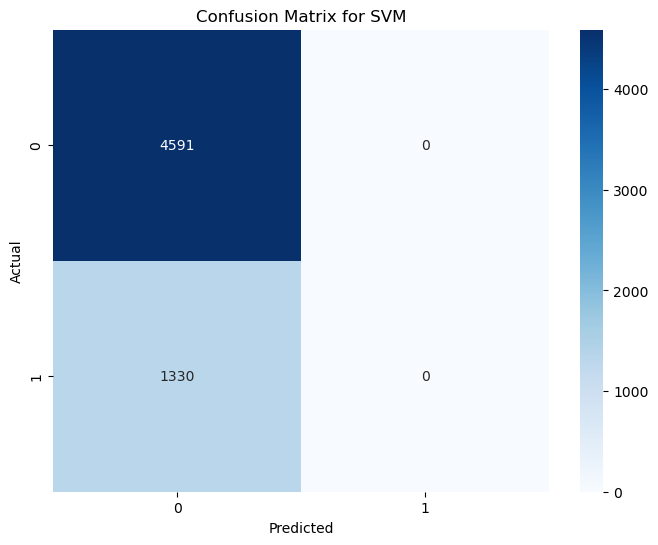

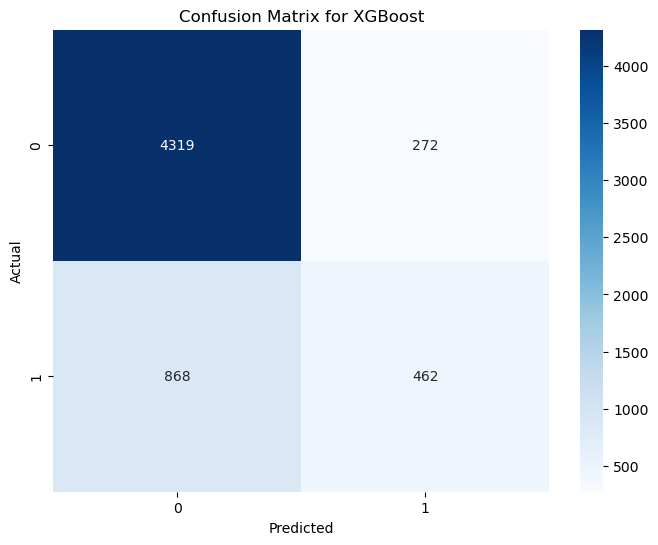

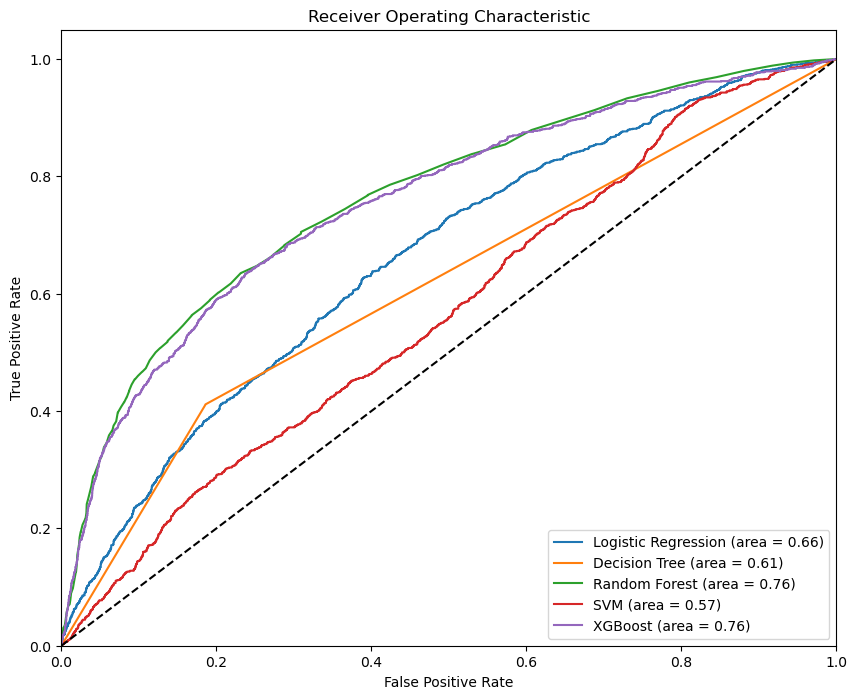

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Store the performance metrics in a DataFrame
results = pd.DataFrame(columns=['Model', 'Accuracy', 'AUC'])

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    results = results.append({'Model': model_name, 'Accuracy': accuracy, 'AUC': roc_auc}, ignore_index=True)

# Sort the results for better visualization
results.sort_values(by='Accuracy', ascending=False, inplace=True)

# Plot the accuracy of each model
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=results, palette='muted')
plt.title('Model Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()

# Plot the AUC of each model
plt.figure(figsize=(10, 6))
sns.barplot(x='AUC', y='Model', data=results, palette='muted')
plt.title('Model AUC Comparison')
plt.xlabel('AUC')
plt.ylabel('Model')
plt.show()

# Plot confusion matrix for each model
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot ROC curve for each model
plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


Model 2 Remove High correlated components

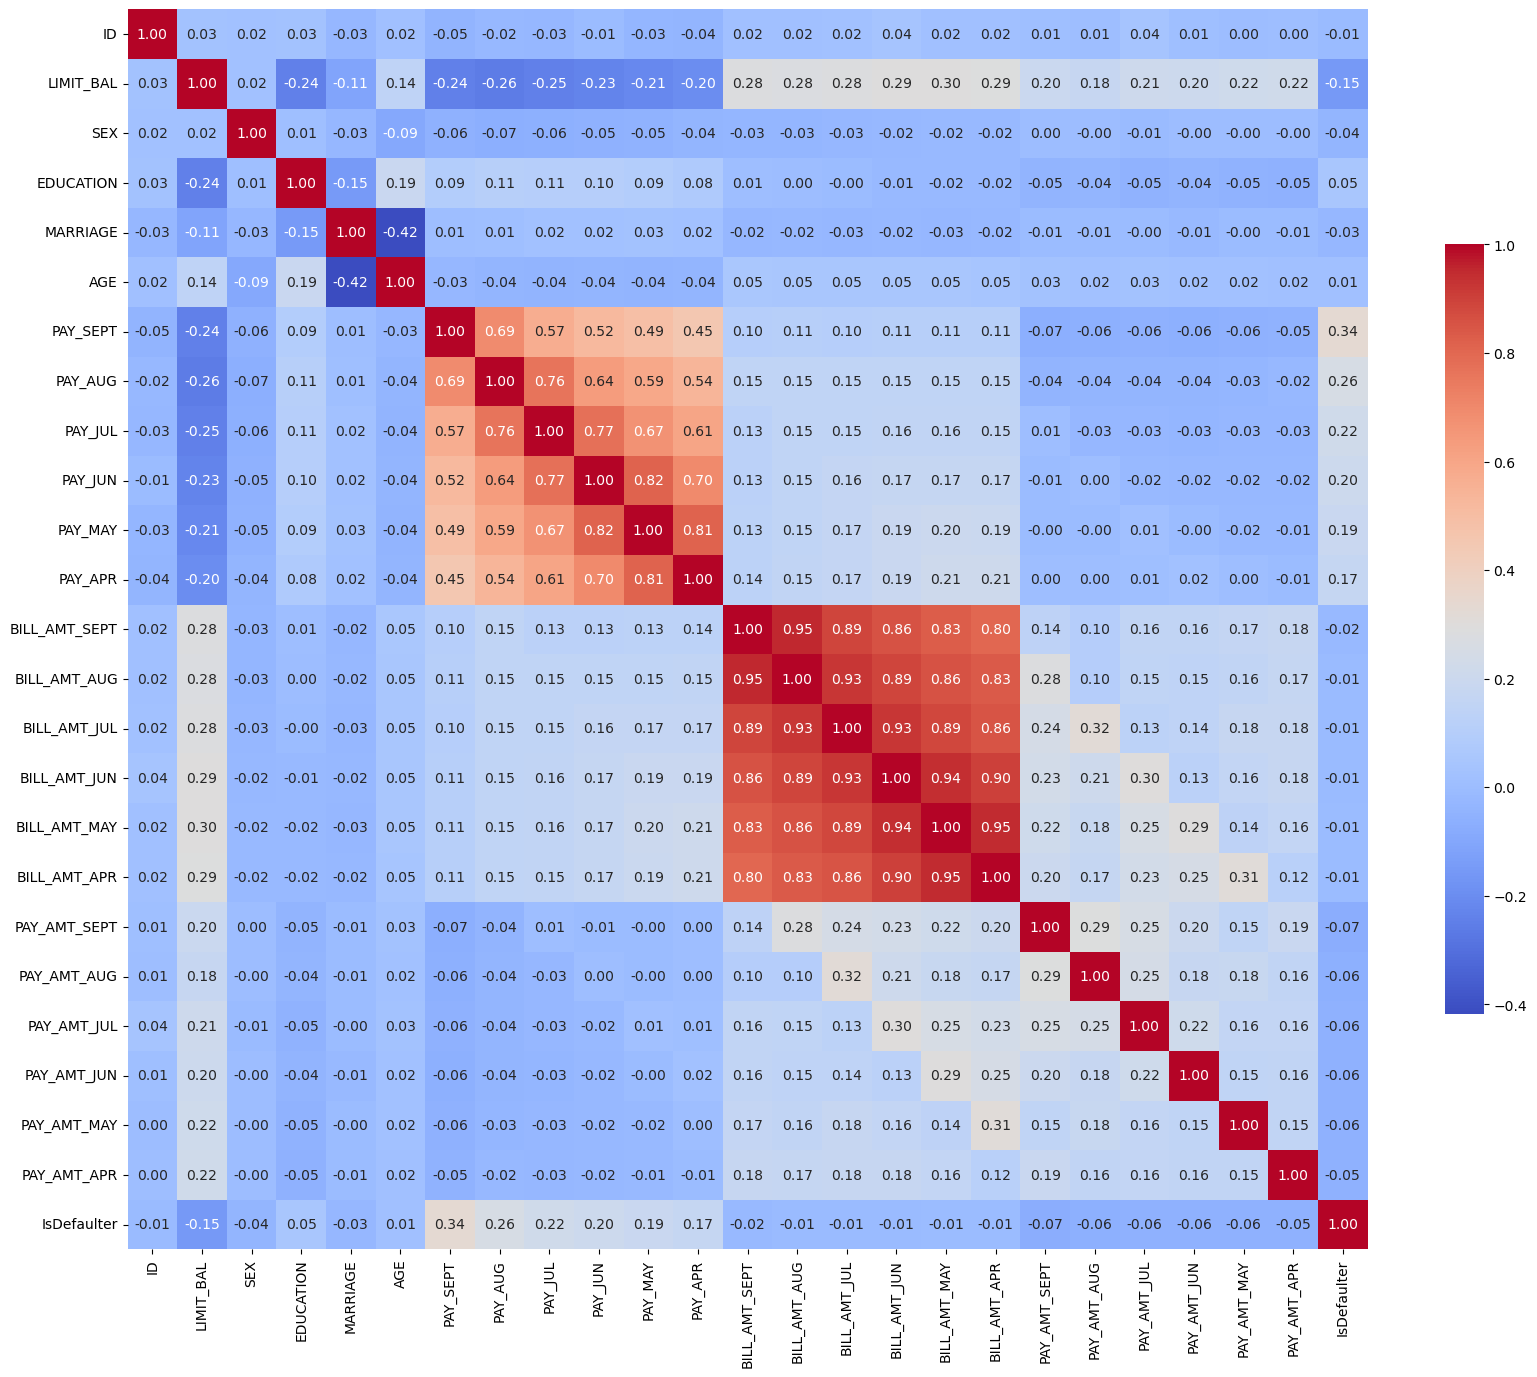

In [37]:
# create correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .5})

# Show plot
plt.show()

# Highly co-related features
# BILL\_AMT1 and BILL\_AMT2 have $\rho = 0.95$
# BILL\_AMT2 and BILL\_AMT3 have $\rho = 0.93$
# BILL\_AMT4 and BILL\_AMT5 have $\rho = 0.94$

In [38]:
#Removed 'ID' and 'Age_Grouped' and BILL_AMT_MONTHs from the features
X_corr = ['LIMIT_BAL','SEX','EDUCATION',	'MARRIAGE',	'AGE',	'PAY_SEPT',	'PAY_AUG',	'PAY_JUL','PAY_JUN', 'PAY_MAY', 'PAY_APR','PAY_AMT_SEPT',	'PAY_AMT_AUG',	'PAY_AMT_JUL',	'PAY_AMT_JUN',	'PAY_AMT_MAY',	'PAY_AMT_APR']
y_corr = pd.Series(['IsDefaulter'])
y_array=y_corr.values
y=y_array.ravel()
# Split the data into a training set (e.g., 80% of the data) and a testing set (e.g., 20% of the data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(df[X_corr], df[y_corr], test_size=0.2, random_state=42)

# The 'test_size' parameter determines the proportion of data used for testing (e.g., 0.2 means 20% for testing).
# The 'random_state' parameter is used to ensure reproducibility. You can set it to any integer value.

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'XGBoost': XGBClassifier()
}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Display the results
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", report)
    print("=" * 50)


Model: Logistic Regression
Accuracy: 0.78
Classification Report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.87      4591
           1       0.00      0.00      0.00      1330

    accuracy                           0.78      5921
   macro avg       0.39      0.50      0.44      5921
weighted avg       0.60      0.78      0.68      5921

Model: Decision Tree
Accuracy: 0.71
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.80      0.81      4591
           1       0.37      0.40      0.39      1330

    accuracy                           0.71      5921
   macro avg       0.60      0.60      0.60      5921
weighted avg       0.72      0.71      0.72      5921

Model: Random Forest
Accuracy: 0.81
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.94      0.88      4591
           1       0.63      0.35      0.45      13

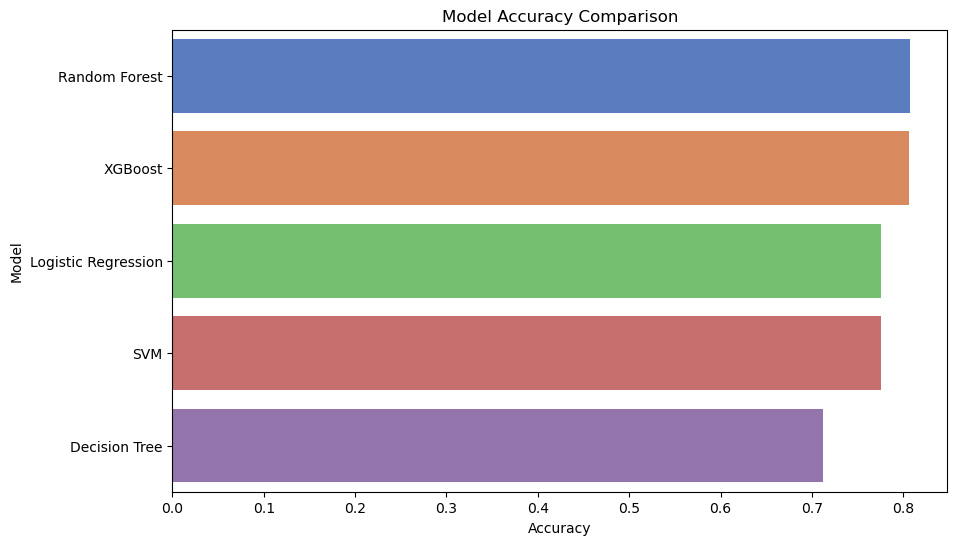

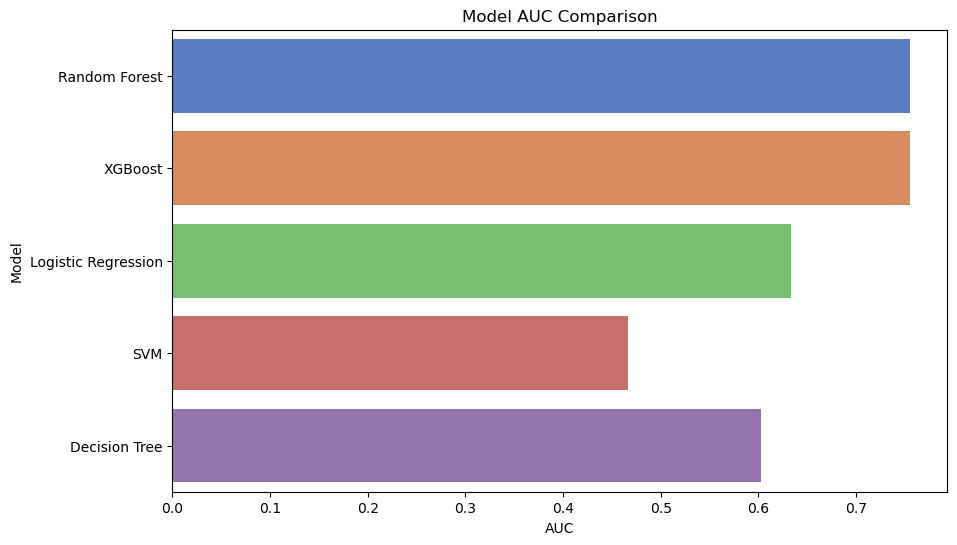

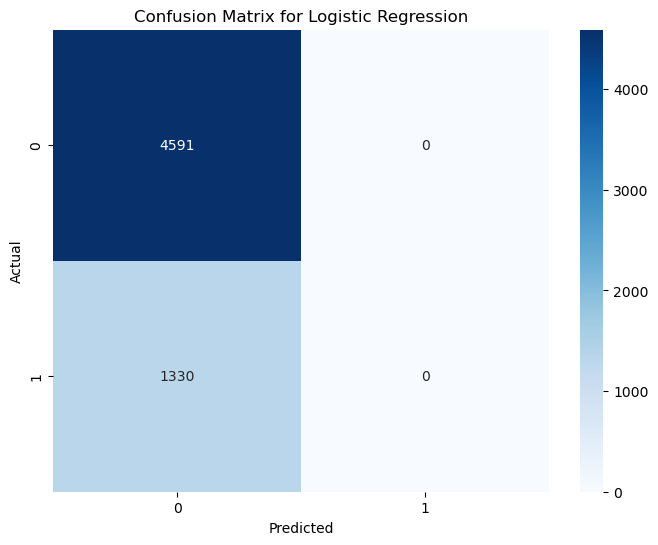

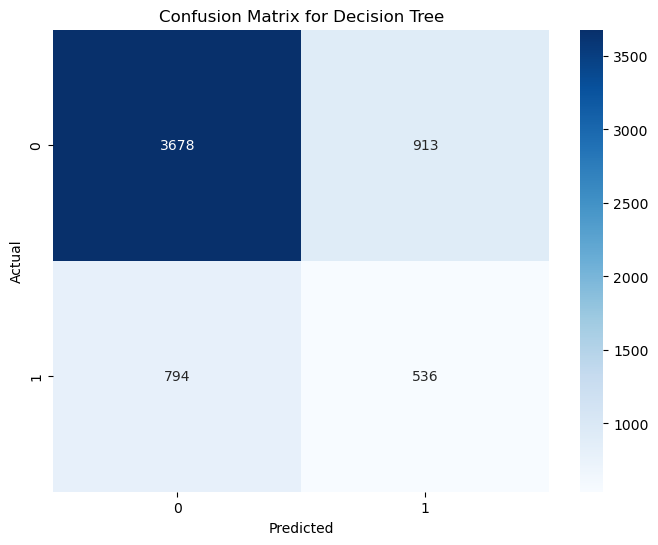

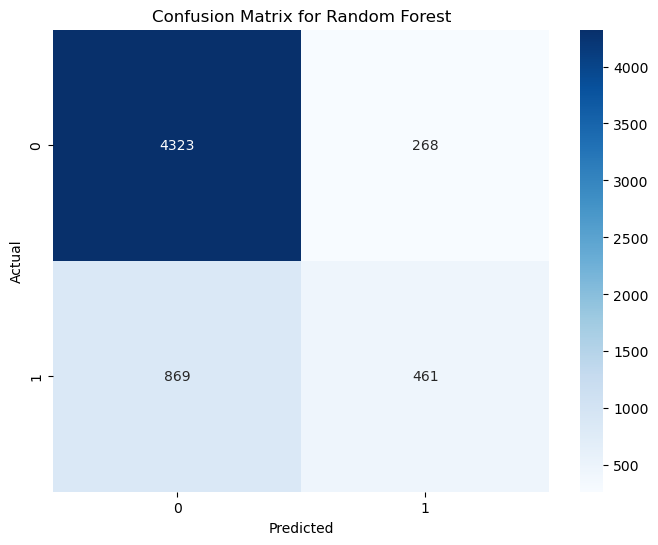

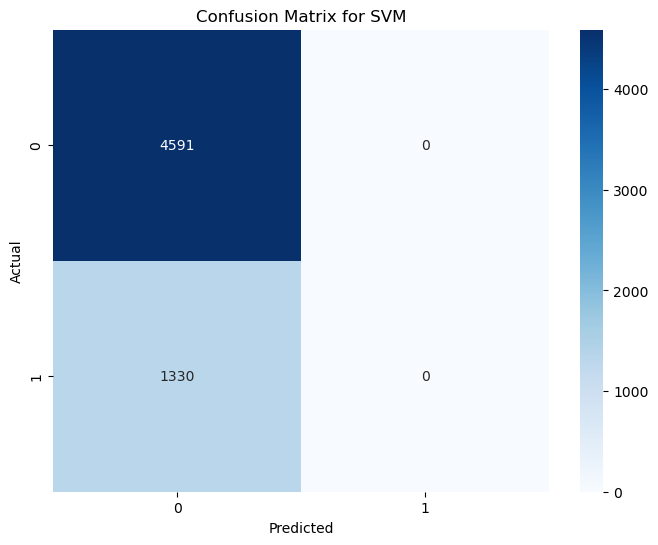

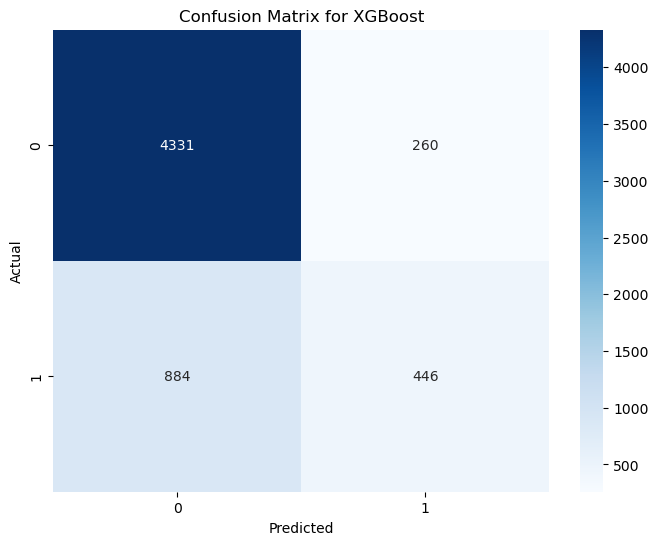

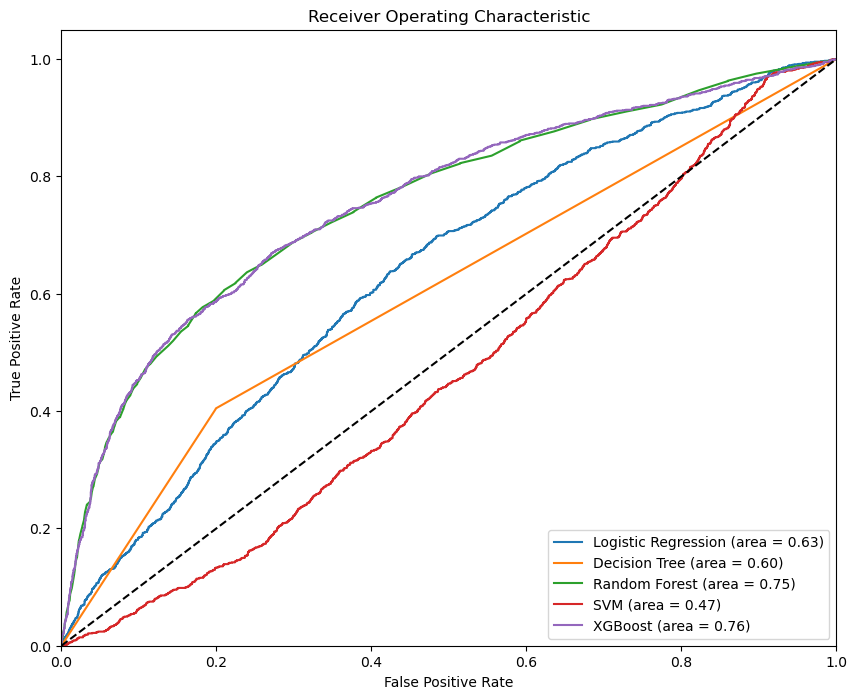

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Store the performance metrics in a DataFrame
results = pd.DataFrame(columns=['Model', 'Accuracy', 'AUC'])

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    results = results.append({'Model': model_name, 'Accuracy': accuracy, 'AUC': roc_auc}, ignore_index=True)

# Sort the results for better visualization
results.sort_values(by='Accuracy', ascending=False, inplace=True)

# Plot the accuracy of each model
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=results, palette='muted')
plt.title('Model Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()

# Plot the AUC of each model
plt.figure(figsize=(10, 6))
sns.barplot(x='AUC', y='Model', data=results, palette='muted')
plt.title('Model AUC Comparison')
plt.xlabel('AUC')
plt.ylabel('Model')
plt.show()

# Plot confusion matrix for each model
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot ROC curve for each model
plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


Model 3 - Removed both Bill_Amount_month and Pay_Month as the are highly correlated

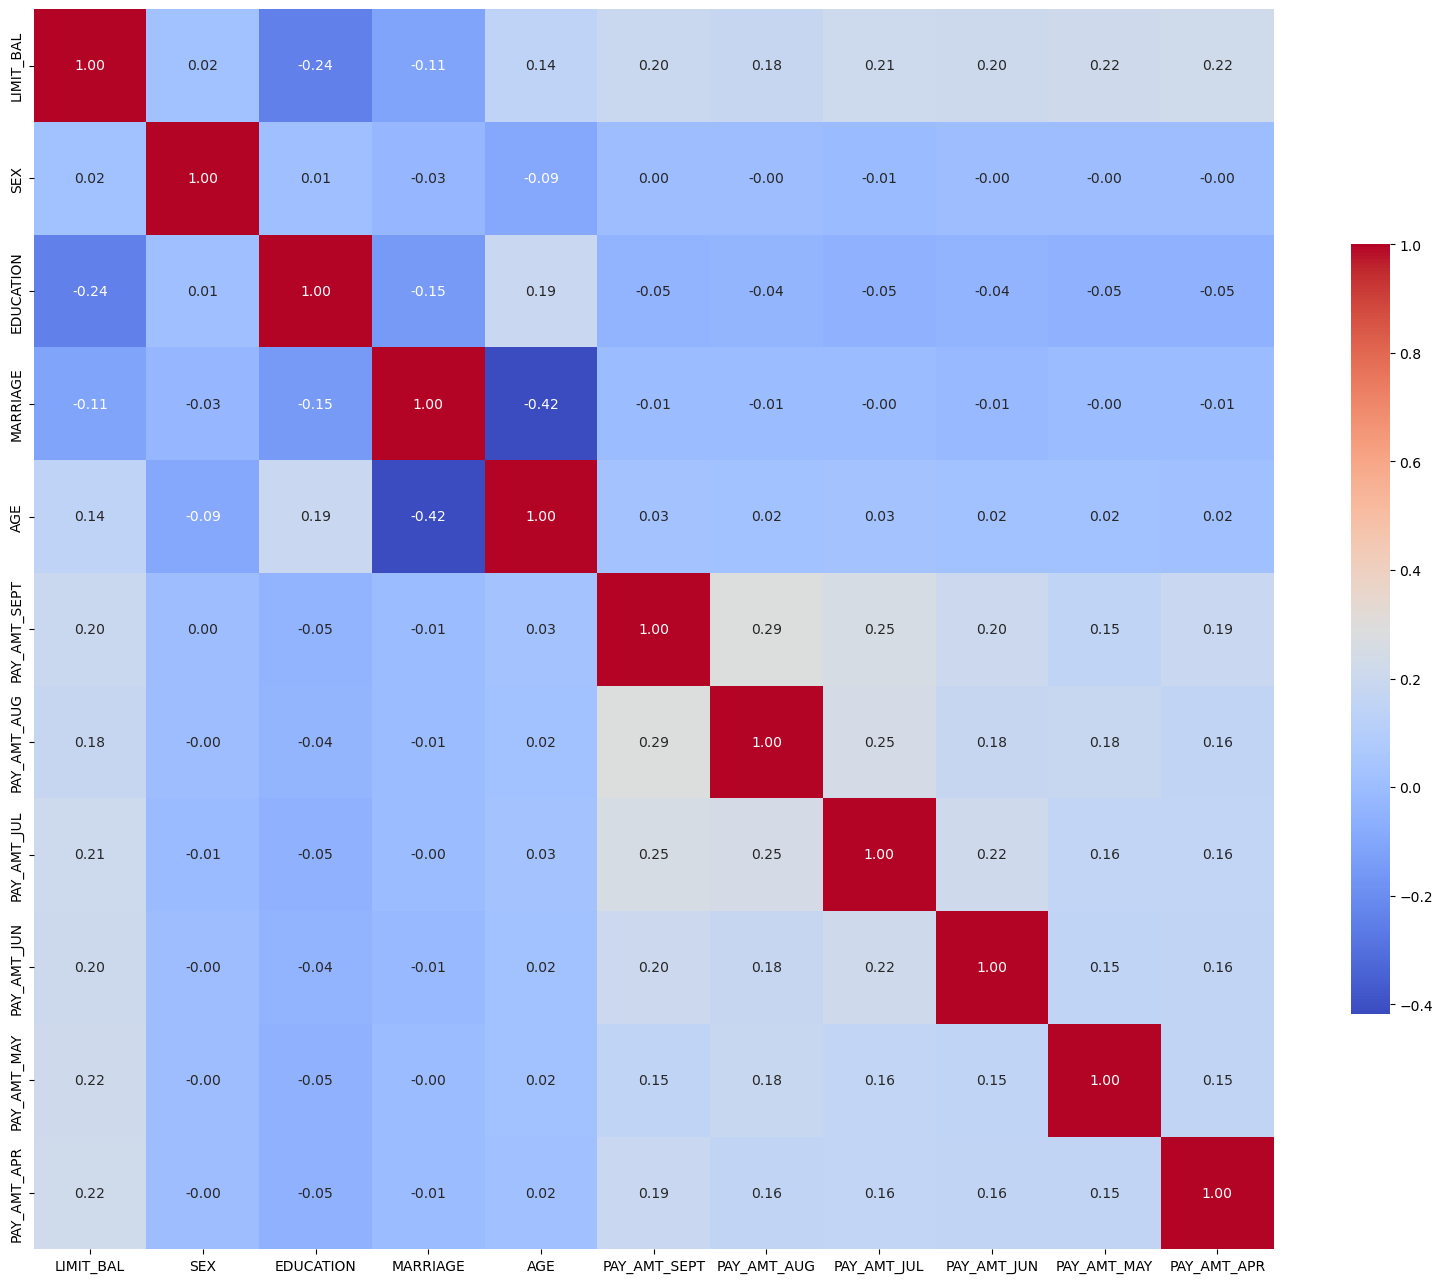

In [41]:
# create correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

df_four = df.drop({'ID','Age_Group','IsDefaulter', 'PAY_SEPT',	'PAY_AUG',	'PAY_JUL','PAY_JUN', 'PAY_MAY', 'PAY_APR','BILL_AMT_SEPT', 'BILL_AMT_AUG', 'BILL_AMT_JUL', 'BILL_AMT_JUN', 'BILL_AMT_MAY',	'BILL_AMT_APR', }, axis=1)
# Calculate the correlation matrix
correlation_matrix = df_four.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .5})

# Show plot
plt.show()


In [42]:
#Removed 'ID' and 'Age_Grouped' and BILL_AMT_MONTHs from the features
X_corr_2 = ['LIMIT_BAL','SEX','EDUCATION',	'MARRIAGE',	'AGE','PAY_AMT_SEPT',	'PAY_AMT_AUG',	'PAY_AMT_JUL',	'PAY_AMT_JUN',	'PAY_AMT_MAY',	'PAY_AMT_APR']
y_corr_2 = pd.Series(['IsDefaulter'])
y_array=y_corr_2.values
y=y_array.ravel()
# Split the data into a training set (e.g., 80% of the data) and a testing set (e.g., 20% of the data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(df[X_corr_2], df[y_corr_2], test_size=0.2, random_state=42)

# The 'test_size' parameter determines the proportion of data used for testing (e.g., 0.2 means 20% for testing).
# The 'random_state' parameter is used to ensure reproducibility. You can set it to any integer value.

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'XGBoost': XGBClassifier()
}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Display the results
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", report)
    print("=" * 50)


Model: Logistic Regression
Accuracy: 0.78
Classification Report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.87      4591
           1       0.00      0.00      0.00      1330

    accuracy                           0.78      5921
   macro avg       0.39      0.50      0.44      5921
weighted avg       0.60      0.78      0.68      5921

Model: Decision Tree
Accuracy: 0.68
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79      4591
           1       0.29      0.32      0.30      1330

    accuracy                           0.68      5921
   macro avg       0.55      0.55      0.55      5921
weighted avg       0.68      0.68      0.68      5921

Model: Random Forest
Accuracy: 0.77
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.96      0.87      4591
           1       0.49      0.13      0.20      13

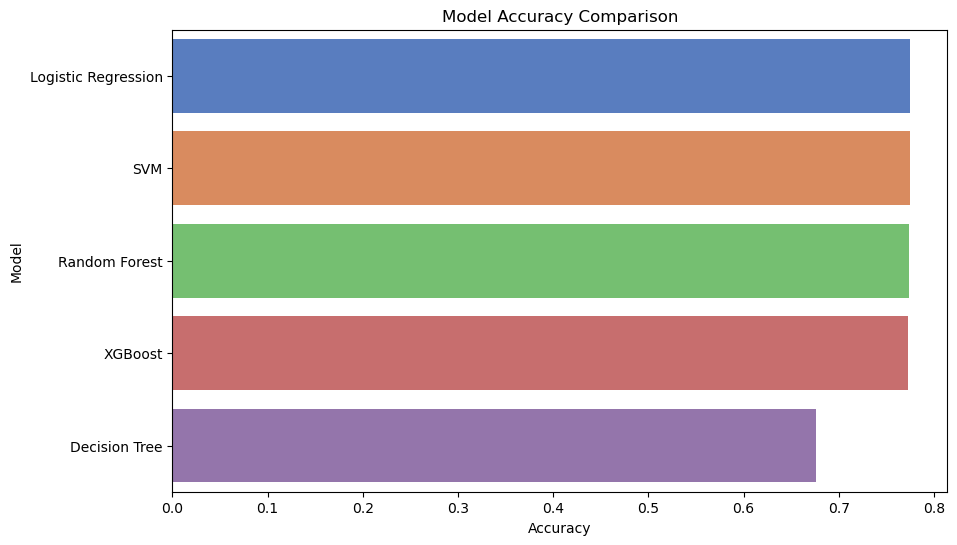

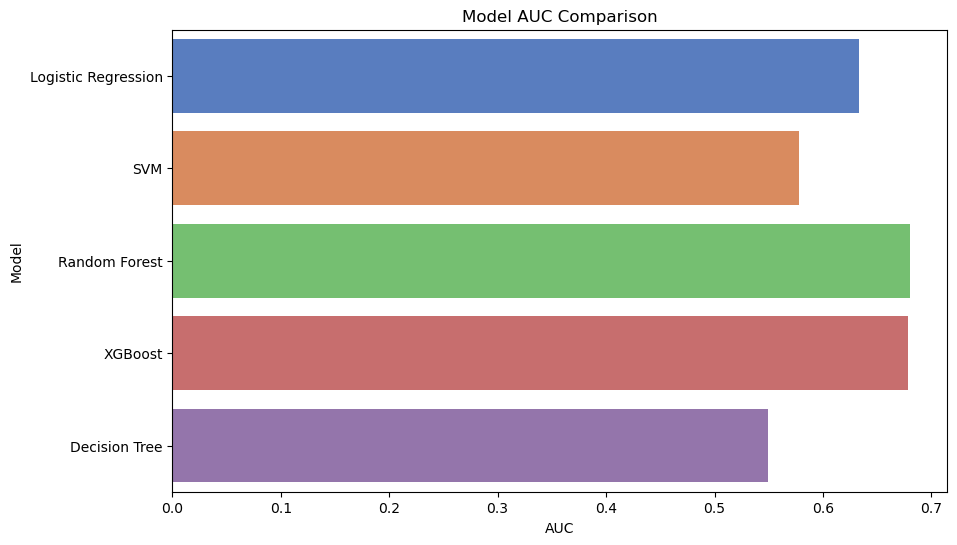

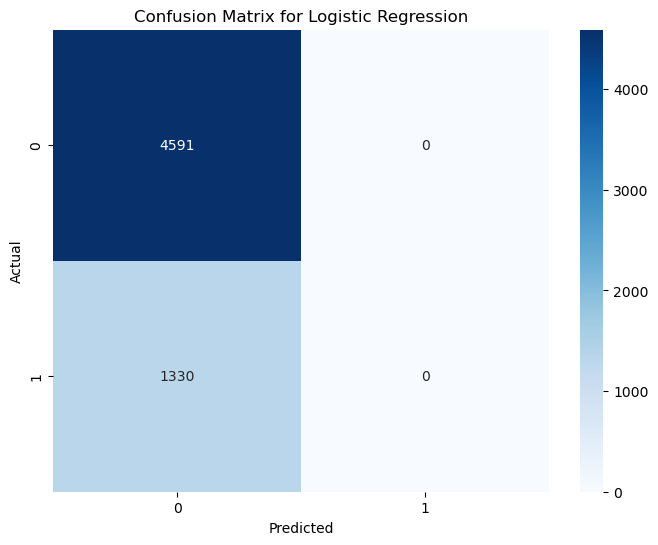

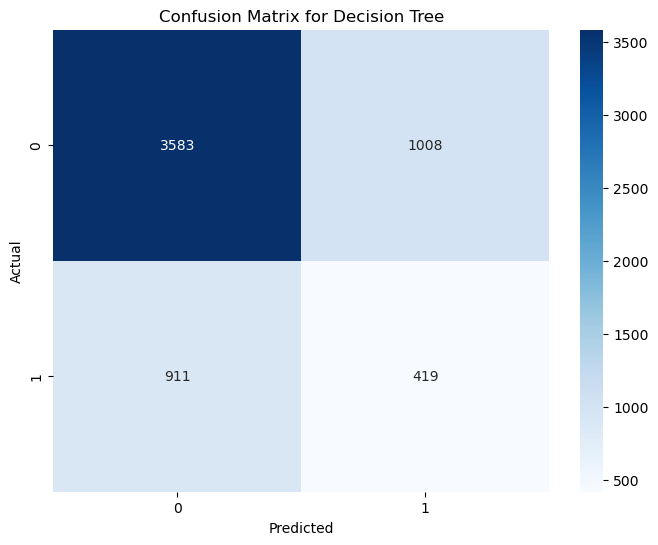

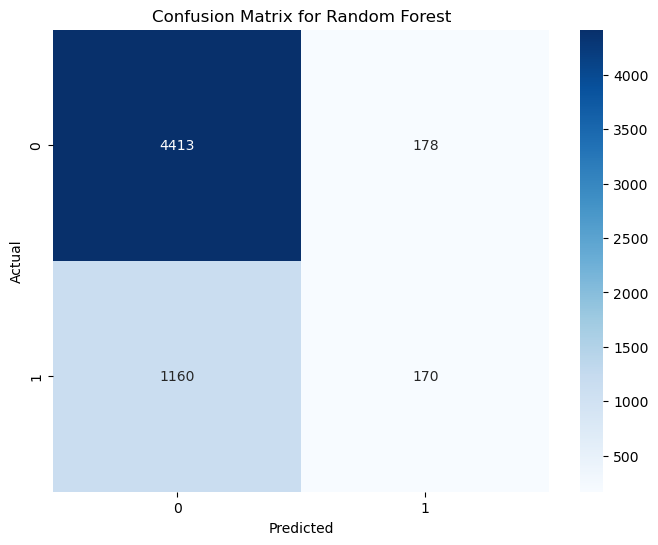

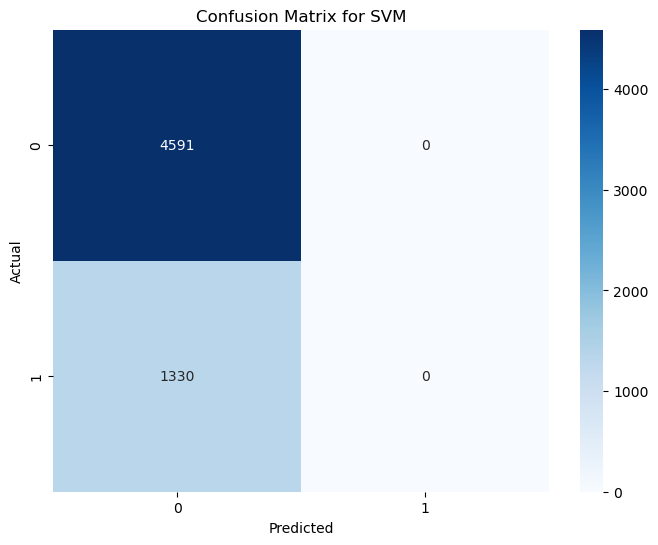

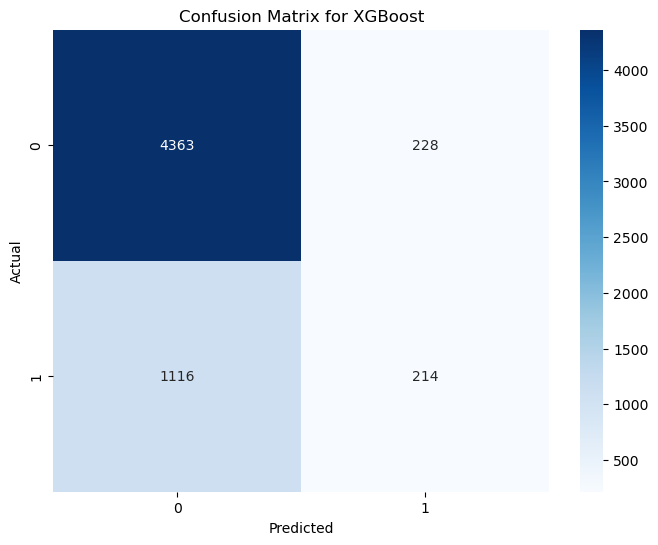

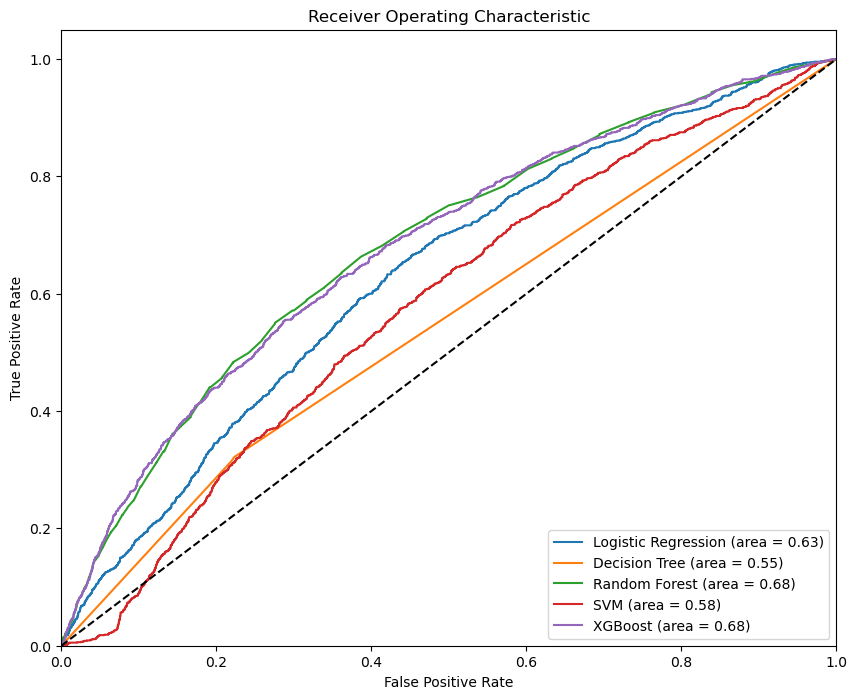

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Store the performance metrics in a DataFrame
results = pd.DataFrame(columns=['Model', 'Accuracy', 'AUC'])

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    results = results.append({'Model': model_name, 'Accuracy': accuracy, 'AUC': roc_auc}, ignore_index=True)

# Sort the results for better visualization
results.sort_values(by='Accuracy', ascending=False, inplace=True)

# Plot the accuracy of each model
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=results, palette='muted')
plt.title('Model Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()

# Plot the AUC of each model
plt.figure(figsize=(10, 6))
sns.barplot(x='AUC', y='Model', data=results, palette='muted')
plt.title('Model AUC Comparison')
plt.xlabel('AUC')
plt.ylabel('Model')
plt.show()

# Plot confusion matrix for each model
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot ROC curve for each model
plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


Model 4 Principal Component Analysis

In [45]:
X_pca = df.drop({'ID','Age_Group','IsDefaulter','BILL_AMT_SEPT', 'BILL_AMT_AUG', 'BILL_AMT_JUL', 'BILL_AMT_JUN', 'BILL_AMT_MAY',	'BILL_AMT_APR'}, axis=1)
y_pca = df['IsDefaulter']

In [46]:
X_pca.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,PAY_MAY,PAY_APR,PAY_AMT_SEPT,PAY_AMT_AUG,PAY_AMT_JUL,PAY_AMT_JUN,PAY_AMT_MAY,PAY_AMT_APR
0,20000,2,2,1,24,3,3,1,1,-1,-1,0,689,0,0,0,0
1,120000,2,2,2,26,1,3,1,1,1,3,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,1,1,1,1,1,1,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,1,1,1,1,1,1,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,1,1,1,1,1,1,2000,36681,10000,9000,689,679


In [47]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_pca, test_size=0.2, random_state=42)

# Standardizing features before applying PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Applying PCA
pca = PCA(n_components=7)  # Adjust the number of components or the explained variance ratio
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# X_train_pca and X_test_pca are the transformed features for further modeling

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'XGBoost': XGBClassifier()
}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train_pca, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_pca)

    # Evaluate the model's performance
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Display the results
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", report)
    print("=" * 50)

Model: Logistic Regression
Accuracy: 0.79
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.98      0.88      4591
           1       0.68      0.15      0.24      1330

    accuracy                           0.79      5921
   macro avg       0.74      0.56      0.56      5921
weighted avg       0.77      0.79      0.74      5921

Model: Decision Tree
Accuracy: 0.71
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.81      4591
           1       0.37      0.39      0.38      1330

    accuracy                           0.71      5921
   macro avg       0.59      0.60      0.59      5921
weighted avg       0.72      0.71      0.71      5921

Model: Random Forest
Accuracy: 0.80
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.94      0.88      4591
           1       0.59      0.31      0.41      13

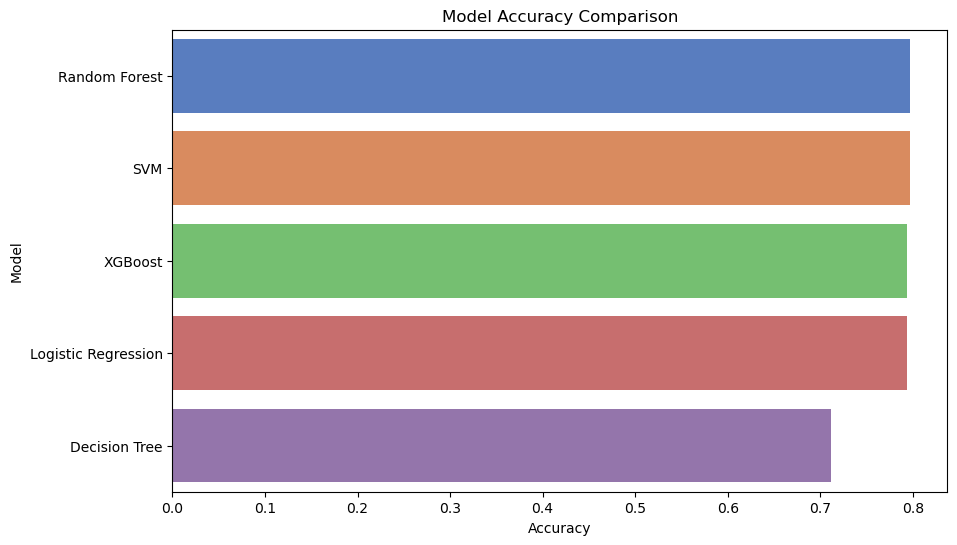

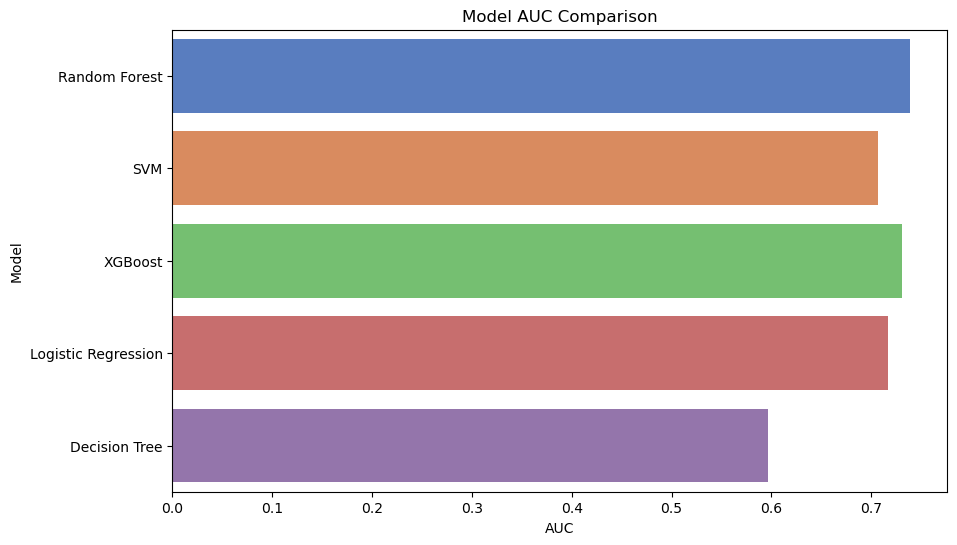

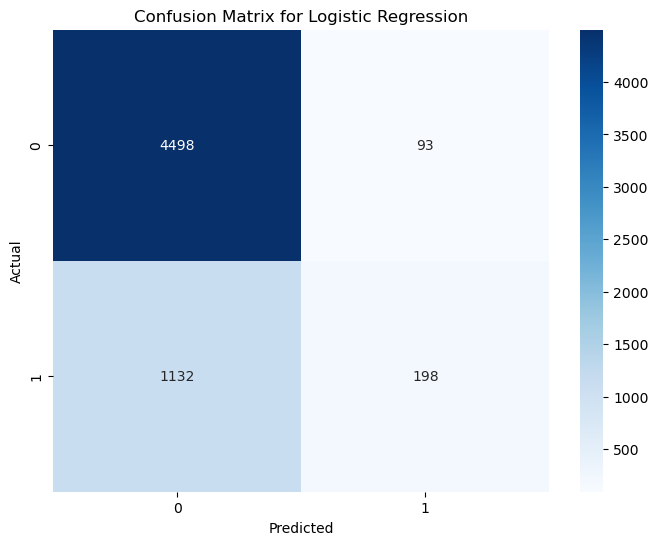

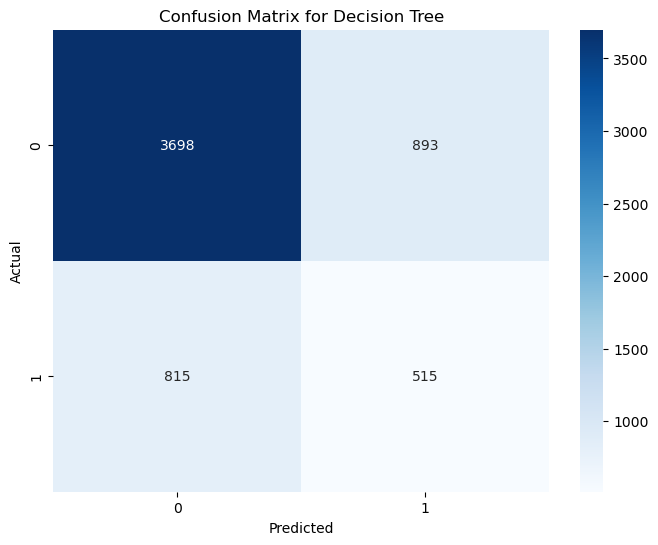

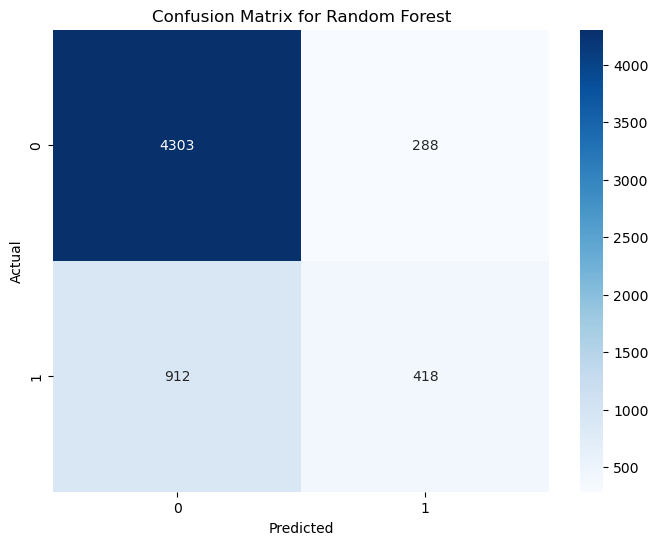

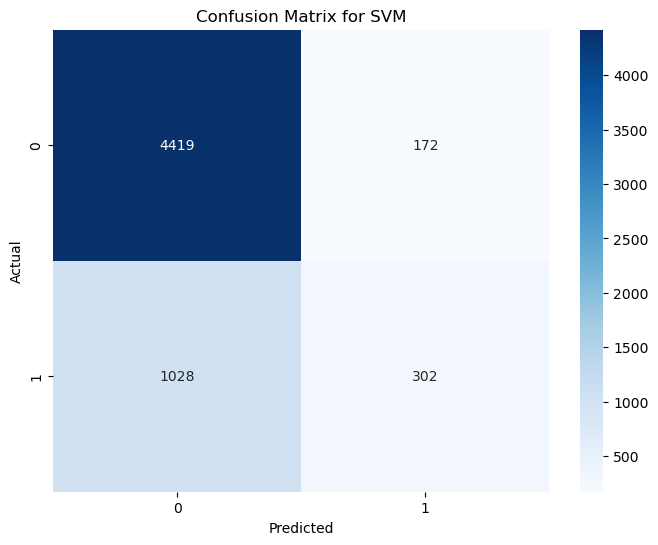

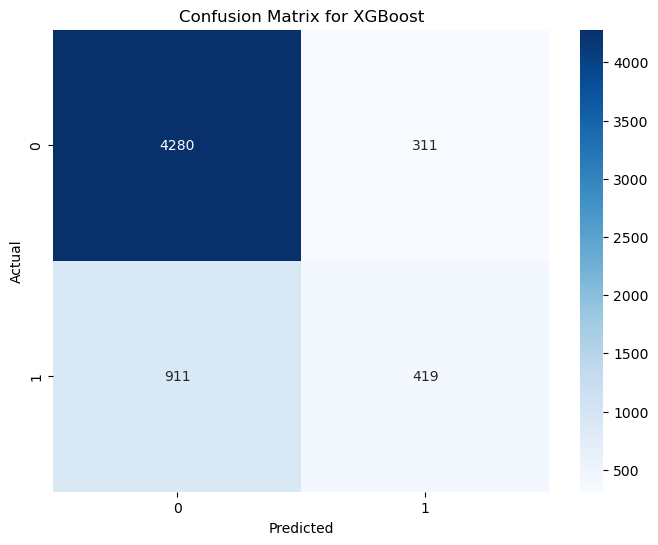

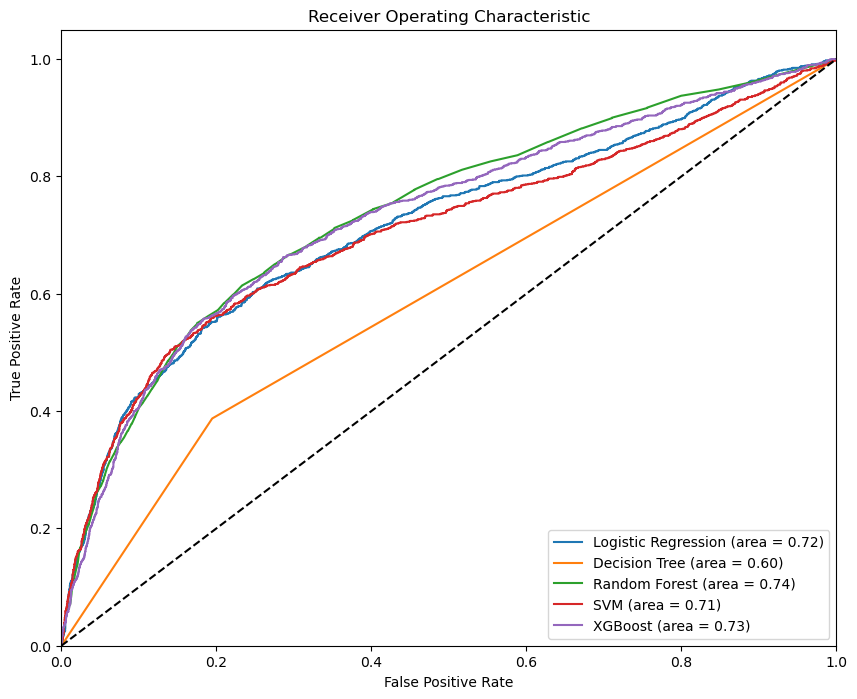

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Store the performance metrics in a DataFrame
results = pd.DataFrame(columns=['Model', 'Accuracy', 'AUC'])

for model_name, model in models.items():
    y_pred = model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_pca)[:, 1])
    roc_auc = auc(fpr, tpr)

    results = results.append({'Model': model_name, 'Accuracy': accuracy, 'AUC': roc_auc}, ignore_index=True)

# Sort the results for better visualization
results.sort_values(by='Accuracy', ascending=False, inplace=True)

# Plot the accuracy of each model
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=results, palette='muted')
plt.title('Model Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()

# Plot the AUC of each model
plt.figure(figsize=(10, 6))
sns.barplot(x='AUC', y='Model', data=results, palette='muted')
plt.title('Model AUC Comparison')
plt.xlabel('AUC')
plt.ylabel('Model')
plt.show()

# Plot confusion matrix for each model
for model_name, model in models.items():
    y_pred = model.predict(X_test_pca)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot ROC curve for each model
plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    y_pred_prob = model.predict_proba(X_test_pca)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
